<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">scRNA-Seq - Foetal Project</h1> 
    <h2 style="color:#483D8B;text-align:center;">Pathways analysis using g:Profiler</h2>
    <br>2 September 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at860@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at19@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">   
    </body>
</html>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import numpy as np
import scipy as sp
from scipy.spatial import distance
from scipy.sparse import issparse
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import sys, os

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

np.warnings.filterwarnings('ignore')

In [2]:
fc   = scRNA_functions()

 * Initialising ...


# Functions

In [3]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

def runPathwaysAnalysis(query, 
                        organism                      = "hsapiens",
                        sources                       = None,
                        user_threshold                = 0.05,
                        all_results                   = False,
                        ordered                       = False,
                        no_evidences                  = True,
                        combined                      = False,
                        measure_underrepresentation   = False,
                        no_iea                        = False,
                        domain_scope                  = 'annotated',
                        numeric_namespace             = '',
                        significance_threshold_method = "fdr",
                        background                    = None,
                        set_domain_scope              = 'custom_annotated',
                        make_plot                     = True,
                        seed                          = None):
    
    
    toExit = False
        
    if sources is None:
        sources = ["GO:MF","GO:CC","GO:BP","KEGG","REAC","WP","TF","MIRNA","HPA","CORUM","HP"]
    else:
        if isinstance(sources, list) == False:
            print("* Error! 'sources' must be a list")
            print()
        
        else:
            for source in sources:
                if source not in ["GO:MF","GO:CC","GO:BP","KEGG","REAC","WP","TF","MIRNA","HPA","CORUM","HP"]:
                    print("* Error! The source '%s' is not available"%source)
                    toExit = True
            if toExit:    
                print("* The valid 'sources' are: 'GO:MF'|'GO:CC'|'GO:BP'|'KEGG'|'REAC'|'WP'|'TF'|'MIRNA'|'HPA'|'CORUM'|'HP'")
                print()

    
    if significance_threshold_method not in ["g_SCS", "bonferroni", "fdr"]:
        print("* Error: 'significance_threshold_method' can only be: 'g_SCS'|'bonferroni'|'fdr'")
        print()
        toExit = True
        
    if domain_scope not in ['annotated', 'known', 'custom', 'custom_annotated']:
        print("* Error: 'domain_scope' can only be: 'annotated'|'known'|'custom'|'custom_annotated'")
        print()
        toExit = True
        
    if user_threshold > 1 or user_threshold < 0:
        print("* Error: 'user_threshold' must be in [0,1]")
        print()
        toExit = True
    
    if background is not None:
        
        if set_domain_scope not in ['custom', 'custom_annotated']:
            print("* Error: 'set_domain_scope' can only be: 'custom'|'custom_annotated'")
            print()
            toExit = True
        
        if toExit == False:
            domain_scope = set_domain_scope
            print("* Setting 'domain_scope' = '%s' ('background' is not None)"%domain_scope)
    
    if toExit:
        return
            
    if sources is None:
        sources = ["GO:MF","GO:CC","GO:BP","KEGG","REAC","WP","TF","MIRNA","HPA","CORUM","HP"]
        
    print("* Using sources:", "|".join(sources))
    
    if len(query) == 0:
        print("* There query set is empty!")
        return None
        
            
    res = gp.profile(query,
                     organism                      = organism,
                     sources                       = sources,
                     user_threshold                = user_threshold,
                     all_results                   = all_results,
                     ordered                       = ordered,
                     no_evidences                  = no_evidences,
                     combined                      = combined,
                     measure_underrepresentation   = measure_underrepresentation,
                     no_iea                        = no_iea,
                     domain_scope                  = domain_scope,
                     numeric_namespace             = numeric_namespace,
                     significance_threshold_method = significance_threshold_method,
                     background                    = background
                     )
    
    res["-log10(p-val)"] = -np.log10(res["p_value"])
    
    if make_plot:
        
        if res.shape[0] == 0:
            print("* There is not any pathway!")
            return res
        
        if seed is None:
            np.random.seed(42)
        else:
            np.random.seed(seed)
            
        import plotly.express as px
        
        res1 = res.copy()
        res1["random_pos"] = np.random.random_sample((res.shape[0],))
        res1["dotsize"]    = np.log1p(res["term_size"].values)
        res1T              = res1.T
        
        
        values = res["source"].value_counts()
        values = dict(zip(values.keys(), values.values))

        texts = []
        for c in res1T:

            s = res1T[c]["native"]+" (%s)"%res1T[c]["term_size"]+"<br>"+res1T[c]["name"]+"<br>"+"%.3e"%res1T[c]["p_value"]
            texts.append(s)
        
        res1["text"]  = texts
        
        colors = {"GO:MF":"#dc3912", "GO:BP":"#ff9900", "GO:CC":"#109618",
                  "KEGG":"#dd4477", "REAC":"#3366cc", "WP":"#0099c6", "TF":"#5574a6",
                  "MIRNA":"#22aa99", "HPA":"#6633cc", "CORUM": "#66aa00", "HP":"#990099"}
        
        colorsToUse = {}
        for cat in sources:
            if cat in list(colors.keys()):
                colorsToUse[cat] = colors[cat]
        
        hover_data = {'random_pos':False,
                      'dotsize':False,
                      'source':False,
                      'native':False,
                      'name':False,
                      'p_value':False,
                      'significant':False,
                      'description':False,
                      'term_size':False,
                      'query_size':False,
                      'intersection_size':False,
                      'effective_domain_size':False,
                      'precision':False,
                      'recall':False,
                      'query':False,
                      'parents':False,
                      '-log10(p-val)':False}

        fig = px.scatter(res1,
                         x                       = 'random_pos',
                         y                       = "-log10(p-val)",
                         facet_col               = "source",
                         size                    = "dotsize",
                         size_max                = 15,
                         template                = "plotly_white",
                         color                   = "source",
                         color_discrete_sequence = list(colorsToUse.values()),
                         hover_data              = hover_data,
                         hover_name              = 'text',
                         width                   = 1000,
                         height                  = 500,
                         category_orders         = {"source": sources}
                         )

        fig.update_xaxes(matches=None, showticklabels=False, title_text=None, showgrid=True, zeroline=False)
        fig.update_yaxes(showgrid=True, zeroline=False, showspikes=True, spikedash='solid', spikethickness=1,
        spikecolor="#999999",
        spikemode="toaxis")

        fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]+" (%d)"%values[a.text.split("=")[-1]]))
        fig.update_layout(hoverlabel={'bgcolor':"white"})
        
        fig.show()
    
    return res, fig

In [4]:
def _calculateMAGs(adata, cells=[], n_top=100, binary=False):     
    dat = adata[adata.obs.index.isin(cells)].copy()
    dat = sc.pp.normalize_per_cell(dat, counts_per_cell_after=100, copy=True)
    if issparse(dat.X):
        dat.var['mean_percent'] = dat.X.mean(axis=0).A1
    else:
        dat.var['mean_percent'] = dat.X.mean(axis=0)
    top = dat.var.sort_values('mean_percent', ascending=False).index[:n_top]
    dat = dat[:, top]
    columns = dat.var_names
    data = dat.X.toarray()
    if binary:
        data = (data > 0).astype(int)
    dat = pd.DataFrame(data, index=dat.obs_names, columns=columns)
    return dat.T

In [5]:
def __runDE(adata,
            group_by,
            group1,
            group2,
            use_raw,
            log,
            min_pct,
            max_pct,
            min_fc,
            where):
    
    
    sc.tl.rank_genes_groups(adata,
                            groupby     = group_by,
                            use_raw     = use_raw,
                            reference   = group1,
                            groups      = [group2],
                            n_genes     = adata.n_vars,
                            key_added   = "%sVS%s"%(group1, group2),
                            method      = 'wilcoxon',
                            corr_method = 'benjamini-hochberg')


    sc.tl.rank_genes_groups(adata,
                            groupby     = group_by,
                            use_raw     = use_raw,
                            reference   = group2,
                            groups      = [group1],
                            n_genes     = adata.n_vars,
                            key_added   = "%sVS%s"%(group2, group1),
                            method      = 'wilcoxon',
                            corr_method = 'benjamini-hochberg')

    sc.tl.filter_rank_genes_groups(adata,
                                   key                    = "%sVS%s"%(group1, group2),
                                   groupby                = group_by,
                                   key_added              = "%sVS%s_filtered"%(group1, group2),
                                   use_raw                = use_raw,
                                   log                    = log,
                                   min_in_group_fraction  = min_pct,
                                   max_out_group_fraction = max_pct,
                                   min_fold_change        = min_fc)


    sc.tl.filter_rank_genes_groups(adata,
                                   key                    = "%sVS%s"%(group2, group1),
                                   groupby                = group_by,
                                   key_added              = "%sVS%s_filtered"%(group2, group1),
                                   use_raw                = use_raw,
                                   log                    = log,
                                   min_in_group_fraction  = min_pct,
                                   max_out_group_fraction = max_pct,
                                   min_fold_change        = min_fc)
    
    
    keys = ["gene", "log2fc", "pval", "pval_adj"]

    result1 = adata.uns["%sVS%s_filtered"%(group1, group2)]
    groups1 = result1['names'].dtype.names
    df1     = pd.DataFrame({keys[idx]: result1[key][group]
                            for group in groups1 for idx,key in enumerate(['names',
                                                                           'logfoldchanges',
                                                                           'pvals',
                                                                           'pvals_adj'])})


    result2 = adata.uns["%sVS%s_filtered"%(group2, group1)]
    groups2 = result2['names'].dtype.names
    df2     = pd.DataFrame({keys[idx]: result2[key][group]
                            for group in groups2 for idx,key in enumerate(['names',
                                                                           'logfoldchanges',
                                                                           'pvals',
                                                                           'pvals_adj'])})


    df1 = df1.dropna()
    df2 = df2.dropna()

    if where == "both":
        both   = list(set(df1["gene"]).intersection(df2["gene"]))

        df = df1[df1["gene"].isin(both)]

    if where == "either":    
        either = list(set(df1["gene"]).union(df2["gene"]))

        genes1 = list(set(either).intersection(set(df1["gene"])))
        genes2 = list(set(either).difference(set(df1["gene"])))

        genes    = df1[df1["gene"].isin(genes1)]["gene"].tolist()     + df2[df2["gene"].isin(genes2)]["gene"].tolist()
        log2fc   = df1[df1["gene"].isin(genes1)]["log2fc"].tolist()   + (-df2[df2["gene"].isin(genes2)]["log2fc"]).tolist()
        pval     = df1[df1["gene"].isin(genes1)]["pval"].tolist()     + df2[df2["gene"].isin(genes2)]["pval"].tolist()
        pval_adj = df1[df1["gene"].isin(genes1)]["pval_adj"].tolist() + df2[df2["gene"].isin(genes2)]["pval_adj"].tolist()

        df = pd.DataFrame(columns = ["gene", "log2fc", "pval", "pval_adj"])    
        df["gene"]     = genes
        df["log2fc"]   = log2fc
        df["pval"]     = pval
        df["pval_adj"] = pval_adj
    
    return df


def runDE_analysis(adata,
                   group_by  = None,
                   group1    = None,
                   group2    = None,
                   use_raw   = True,
                   log       = True,
                   plotGenes = True,
                   topGenes  = 50,
                   showDf    = False,
                   min_pct   = 0.1,
                   max_pct   = 1.0,
                   min_fc    = 0.0,
                   where     = "both",
                   logfc_th  = 1.0,
                   pval_th   = 1e-6,
                   figsize   = (12,12)):
    
    sns.set_style("white")
    
    if group_by not in adata.obs.columns.tolist():
        print("Provide a valid variable to group the data")
        return
    
    if group1 is None or group2 is None:
        if group1 is None:
            print("Provide a valid value for group1")
        if group2 is None:
            print("Provide a valid value for group2")
        return
    
    where = where.lower()
    if where not in ["both", "either"]:
        print("'where' must be equal to 'both' or 'either'")
        return
    
    
    df = __runDE(adata, group_by, group1, group2, use_raw, log, min_pct, max_pct, min_fc, where)

    df["-log10(p-val adj)"] = -np.log10(df["pval_adj"])

    df = df.dropna()
    df = df.sort_values(by=["log2fc"], ascending=False)
    
    if showDf:
        display(df)
    
    df['color']  = "0"
    df['marker'] = "0"
    df['color'].fillna('0',  inplace=True) # intermediate
    df['marker'].fillna("No Sig.", inplace=True) # intermediate
    
    # ************************************************* Both log2fc and p-val *************************************************
#     indeces = df[df['log2fc'] >= 1].nlargest(topGenes, "log2fc").index
    indeces = df[(np.abs(df['log2fc']) >= logfc_th) & (df['-log10(p-val adj)'] >= -np.log10(pval_th))].index
    genes = df['color'][indeces]
    df['color'].replace(genes, "3", inplace=True)
    
    # ************************************************* Only log2fc *************************************************
    indeces = df[(np.abs(df['log2fc']) >= logfc_th) & (df['-log10(p-val adj)'] < -np.log10(pval_th))].index
    genes = df['color'][indeces]
    df['color'].replace(genes, "2", inplace=True)
    
    # ************************************************* Only p-val *************************************************
    indeces = df[(np.abs(df['log2fc']) <= logfc_th) & (df['-log10(p-val adj)'] >= -np.log10(pval_th))].index
    genes = df['color'][indeces]
    df['color'].replace(genes, "1", inplace=True)
    
    
    # ************************************************* Marker group1 *************************************************
    indeces = df[df['log2fc'] >= logfc_th].index
    genes = df['marker'][indeces]
    df['marker'].replace(genes, "2", inplace=True)
    
    # ************************************************* Marker group2 *************************************************
    indeces = df[df['log2fc'] <= -logfc_th].index
    genes = df['marker'][indeces]
    df['marker'].replace(genes, "1", inplace=True)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set(font_scale=1.5)
    
    colors  = ["#A9A9A9", "#722F37", "#0099ff", "#6A5ACD"]
    labels  = ["No Sig.", "p-val", "$log_2$FC", "$log_2$FC & p-val"]
    
    colors1  = []
    labels1  = ["Significance"]
    
    for c in np.unique(df['color']):
        colors1.append(colors[int(c)])
        labels1.append(labels[int(c)])
    
    labels1  += ["Group"]
    for m in np.unique(df['marker']):
        if int(m) == 0:
            labels1.append("Both")
        elif int(m) == 1:
            labels1.append(group1)
        elif int(m) == 2:
            labels1.append(group2)
            
        
    
    g = sns.scatterplot(x="log2fc",
                        y="-log10(p-val adj)",
                        hue="color",
                        style="marker",
                        palette=colors1,
                        data=df,
                        alpha=1,
                        s=figsize[0]*10,
                        ax=ax,
                        legend="full",
                        markers=["o", "X", '^'])
    
    if plotGenes:
        listTopGenes = df[(np.abs(df['log2fc']) >= logfc_th) &
                          (df['-log10(p-val adj)'] >= -np.log10(pval_th))].index.tolist()

        listTopGenes = [df[df.index.isin(listTopGenes)]["log2fc"].tolist(),
                        df[df.index.isin(listTopGenes)]["-log10(p-val adj)"].tolist(),
                        df[df.index.isin(listTopGenes)]["gene"].tolist()]
                        
        if topGenes < 0 or isinstance(topGenes, int) == False:
            for i in range(0, len(listTopGenes[0])):
                plt.text(listTopGenes[0][i],
                         listTopGenes[1][i],
                         listTopGenes[2][i],
                         fontsize=12,
                         fontname="sans-serif")
        else:

            listTopGenes = pd.DataFrame(index   = listTopGenes[:][-1],
                                columns = ["log2fc", "-log10(p-val adj)"],
                                data    = np.array(listTopGenes[:][0:2]).T)

            left   = listTopGenes[listTopGenes["log2fc"]<0]
            right  = listTopGenes[listTopGenes["log2fc"]>=0]

            left  = left.sort_values(by=['log2fc', '-log10(p-val adj)'],
                                     ascending=[True, False])

            right = right.sort_values(by=['log2fc', '-log10(p-val adj)'],
                                      ascending=[False, False])

            left   = left[left["log2fc"]<0][:topGenes].index.tolist()
            right  = right[right["log2fc"]>=0][:topGenes].index.tolist()
            
            toShow = left + right

            listTopGenes = listTopGenes[listTopGenes.index.isin(toShow)]

            for idx,gene in enumerate(listTopGenes.index):

                plt.text(listTopGenes["log2fc"][idx],
                         listTopGenes["-log10(p-val adj)"][idx],
                         gene,
                         fontsize=12,
                         fontname="sans-serif")

        
        
    plt.axhline(y=-np.log10(pval_th), linestyle="--", color="k")
    plt.axvline(x=logfc_th, linestyle="--", color="k")
    plt.axvline(x=-logfc_th, linestyle="--", color="k")

    plt.xlabel('log2FC',fontsize=15, fontname="sans-serif", fontweight="bold")
    plt.ylabel('-log10(p-val adj)', fontsize=15, fontname="sans-serif", fontweight="bold")
    plt.xticks(fontsize=12, fontname="sans-serif")
    plt.yticks(fontsize=12, fontname="sans-serif")
    
    for t, l in zip(g.legend_.texts, labels1):
        t.set_text(l)
    
    g.legend_.set_frame_on(False)
    g.legend_.set_bbox_to_anchor((1.25, 1))
                        
    ax.add_artist(g.legend_)
    
    sns.despine(offset=10, trim=False)
    plt.tight_layout()
#     plt.show(block="False")
    
    df["difference"] = "No"

    df["difference"][df["color"] == '3'] = "High"
    df["difference"][df["color"] == '2'] = "Medium"

    df["group"]      = "Group"
    df["group"][df["marker"] == '1'] = group1
    df["group"][df["marker"] == '2'] = group2

#     df = df[(df["difference"] == "High") | (df["difference"] == "Medium")]

    genes = df["gene"].tolist()
    
    g1 = adata[adata.obs[group_by]==group1]
    g2 = adata[adata.obs[group_by]==group2]
    
    if use_raw:
        expG1 = g1.raw.X[:, g1.raw.var.index.isin(genes)]
        expG2 = g2.raw.X[:, g2.raw.var.index.isin(genes)]
    else:
        expG1 = g1.X[:, g1.var.index.isin(genes)]
        expG2 = g2.X[:, g2.var.index.isin(genes)]
        
    expG1 = 100*np.sum(expG1>0, axis=0)/g1.n_obs
    expG2 = 100*np.sum(expG2>0, axis=0)/g2.n_obs
    
    df["% cells group 1"] = expG1
    df["% cells group 2"] = expG2

    df.set_index(["gene"], inplace=True)
    del df.index.name
    return df[["log2fc", "-log10(p-val adj)", "difference", "group", "% cells group 1", "% cells group 2"]], fig

# Loading data

In [6]:
merged = sc.read_h5ad('../Data/ScanpyObjets/MergedAllSamples_annotated.h5ad')

In [7]:
sources       = ["GO:MF","GO:CC","GO:BP","KEGG","REAC", "TF","MIRNA"]
th_perc_cells = 30

# HSC-MPPs

In [8]:
group1 = pd.read_csv("../MetaData/Resources/Subsampling/ShortGroup_HSC-MPPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/Subsampling/Subsampled_HSC-MPPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

whole = merged[merged.obs.index.isin(group1+group2)]

np.unique(whole.obs["Cluster"])

array(['HSC-MPPs'], dtype=object)

In [9]:
liver = whole[whole.obs["origin"]=="Liver"]
femur = whole[whole.obs["origin"]=="Femur"]

Trying to set attribute `.uns` of view, copying.


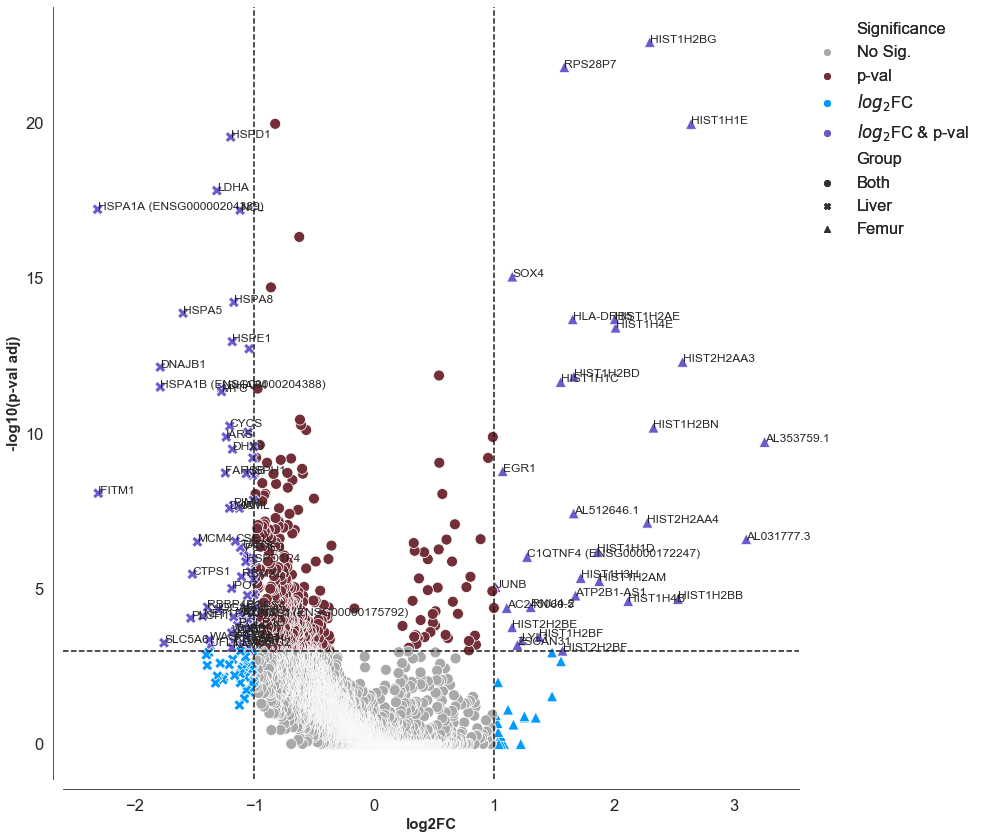

In [10]:
dataframe, fig = runDE_analysis(whole,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                plotGenes = True)

DEGs = dataframe[dataframe["difference"]=="High"]

## Liver

In [11]:
DEGs_liver = DEGs[DEGs["group"] == "Liver"].index.tolist()

print("* Using the DEGs ...")
query = liver.var[liver.var.index.isin(DEGs_liver)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(liver.raw.X > 0, axis=0)/liver.n_obs)
df       = pd.DataFrame(index=liver.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))


res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 77
* Number of background genes: 5547

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA


## Femur

In [12]:
DEGs_femur = DEGs[DEGs["group"] == "Femur"].index.tolist()

print("* Using the DEGs ...")
query = femur.var[femur.var.index.isin(DEGs_femur)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(femur.raw.X>0, axis=0)/femur.n_obs)
df       = pd.DataFrame(index=femur.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))

res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 31
* Number of background genes: 3962

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA


# HSC-MPPs-Cycle

In [13]:
group1 = pd.read_csv("../MetaData/Resources/Subsampling/ShortGroup_HSC-MPPs-Cycle_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/Subsampling/Subsampled_HSC-MPPs-Cycle_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

whole = merged[merged.obs.index.isin(group1+group2)]

np.unique(whole.obs["Cluster"])

array(['HSC-MPPs-Cycle'], dtype=object)

In [14]:
liver = whole[whole.obs["origin"]=="Liver"]
femur = whole[whole.obs["origin"]=="Femur"]

Trying to set attribute `.uns` of view, copying.


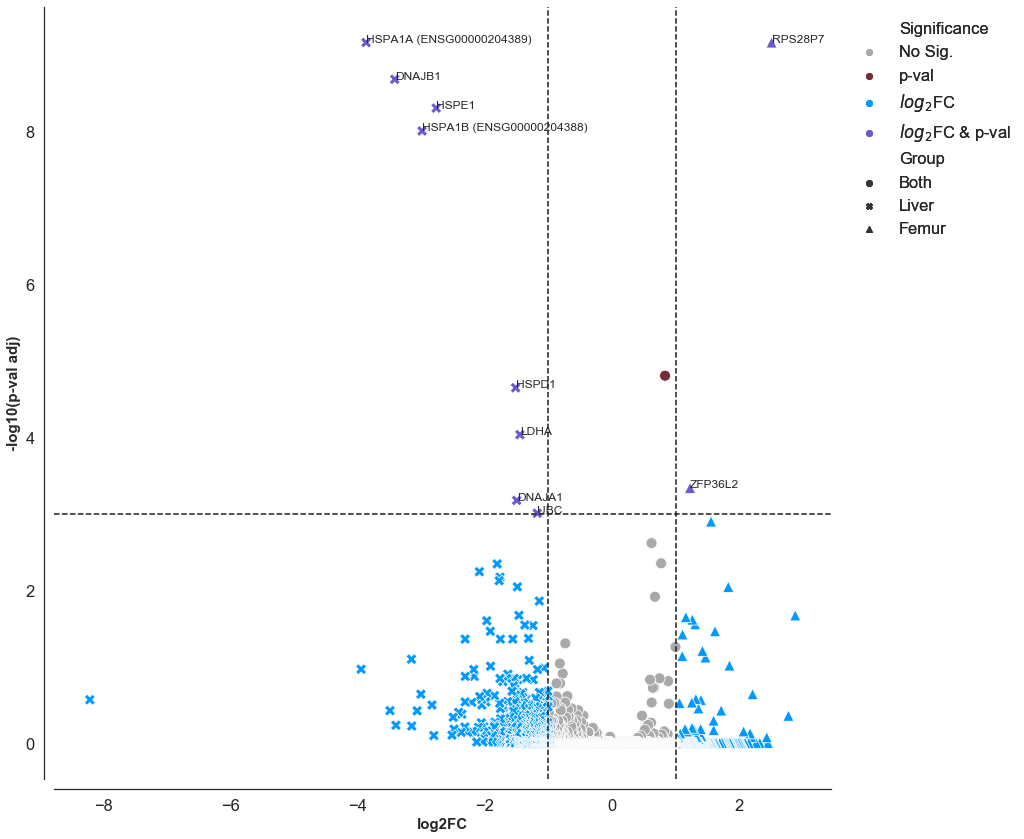

In [15]:
dataframe, fig = runDE_analysis(whole,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                plotGenes = True)

DEGs = dataframe[dataframe["difference"]=="High"]

## Liver

In [16]:
DEGs_liver = DEGs[DEGs["group"] == "Liver"].index.tolist()

print("* Using the DEGs ...")
query = liver.var[liver.var.index.isin(DEGs_liver)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(liver.raw.X > 0, axis=0)/liver.n_obs)
df       = pd.DataFrame(index=liver.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))


res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 8
* Number of background genes: 6409

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA


## Femur

In [17]:
DEGs_femur = DEGs[DEGs["group"] == "Femur"].index.tolist()

print("* Using the DEGs ...")
query = femur.var[femur.var.index.isin(DEGs_femur)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(femur.raw.X>0, axis=0)/femur.n_obs)
df       = pd.DataFrame(index=femur.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))

res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 2
* Number of background genes: 5250

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There is not any pathway!


# MEMPs

In [18]:
group1 = pd.read_csv("../MetaData/Resources/Subsampling/ShortGroup_MEMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/Subsampling/Subsampled_MEMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

whole = merged[merged.obs.index.isin(group1+group2)]

np.unique(whole.obs["Cluster"])

array(['MEMPs'], dtype=object)

In [19]:
liver = whole[whole.obs["origin"]=="Liver"]
femur = whole[whole.obs["origin"]=="Femur"]

Trying to set attribute `.uns` of view, copying.


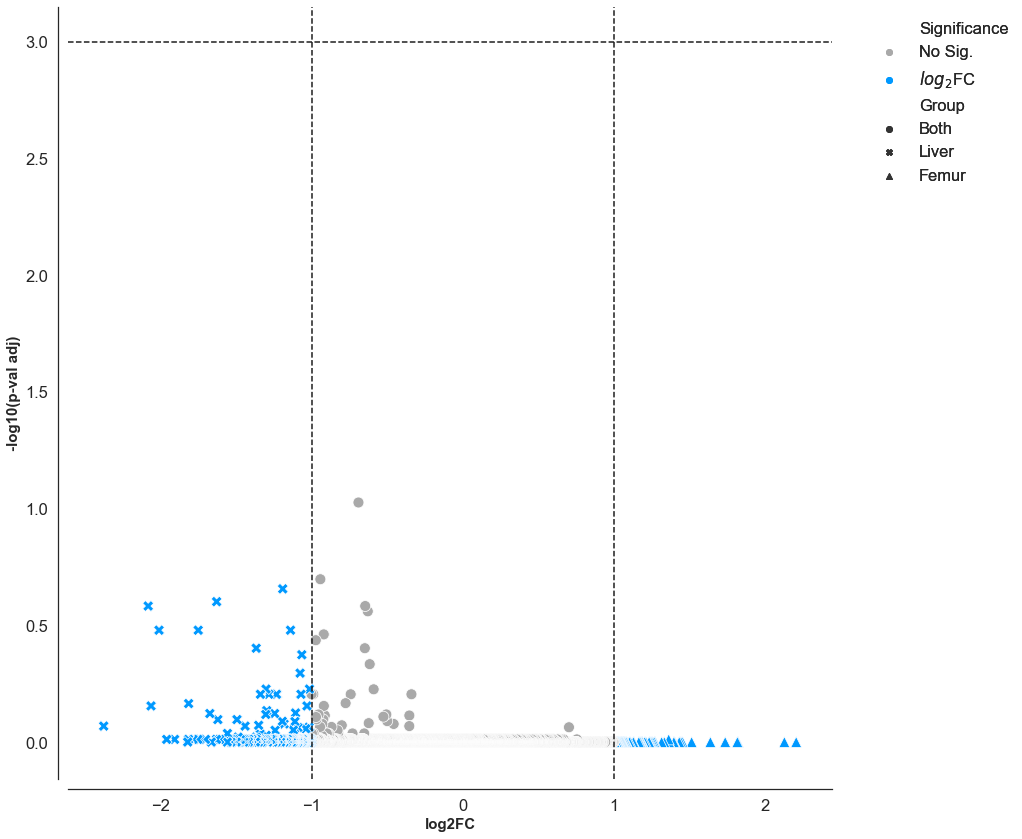

In [20]:
dataframe, fig = runDE_analysis(whole,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                plotGenes = True)

DEGs = dataframe[dataframe["difference"]=="High"]

## Liver

In [21]:
DEGs_liver = DEGs[DEGs["group"] == "Liver"].index.tolist()

print("* Using the DEGs ...")
query = liver.var[liver.var.index.isin(DEGs_liver)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(liver.raw.X > 0, axis=0)/liver.n_obs)
df       = pd.DataFrame(index=liver.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))


res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 6807

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!


## Femur

In [22]:
DEGs_femur = DEGs[DEGs["group"] == "Femur"].index.tolist()

print("* Using the DEGs ...")
query = femur.var[femur.var.index.isin(DEGs_femur)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(femur.raw.X>0, axis=0)/femur.n_obs)
df       = pd.DataFrame(index=femur.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))

res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 5994

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!


# MEMPs-Cycle

In [23]:
group1 = pd.read_csv("../MetaData/Resources/Subsampling/ShortGroup_MEMPs-Cycle_Femur_vs_Liver.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/Subsampling/Subsampled_MEMPs-Cycle_Femur_vs_Liver.csv",
                     header=None, sep=",")[0].tolist()

whole = merged[merged.obs.index.isin(group1+group2)]

np.unique(whole.obs["Cluster"])

array(['MEMPs-Cycle'], dtype=object)

In [24]:
liver = whole[whole.obs["origin"]=="Liver"]
femur = whole[whole.obs["origin"]=="Femur"]

Trying to set attribute `.uns` of view, copying.


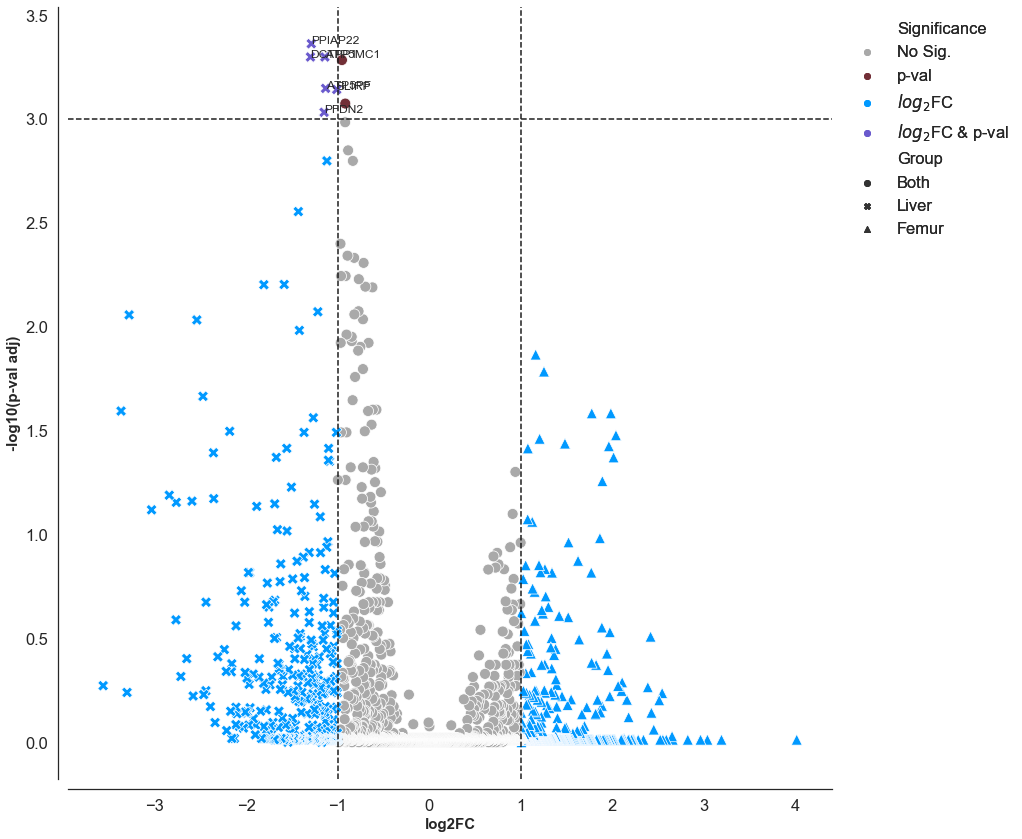

In [25]:
dataframe, fig = runDE_analysis(whole,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                plotGenes = True)

DEGs = dataframe[dataframe["difference"]=="High"]

## Liver

In [26]:
DEGs_liver = DEGs[DEGs["group"] == "Liver"].index.tolist()

print("* Using the DEGs ...")
query = liver.var[liver.var.index.isin(DEGs_liver)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(liver.raw.X > 0, axis=0)/liver.n_obs)
df       = pd.DataFrame(index=liver.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))


res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 6
* Number of background genes: 7892

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA


## Femur

In [27]:
DEGs_femur = DEGs[DEGs["group"] == "Femur"].index.tolist()

print("* Using the DEGs ...")
query = femur.var[femur.var.index.isin(DEGs_femur)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(femur.raw.X>0, axis=0)/femur.n_obs)
df       = pd.DataFrame(index=femur.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))

res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 7493

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!


# LMPs

In [28]:
group1 = pd.read_csv("../MetaData/Resources/Subsampling/ShortGroup_LMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/Subsampling/Subsampled_LMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

whole = merged[merged.obs.index.isin(group1+group2)]

np.unique(whole.obs["Cluster"])

array(['LMPs'], dtype=object)

In [29]:
liver = whole[whole.obs["origin"]=="Liver"]
femur = whole[whole.obs["origin"]=="Femur"]

Trying to set attribute `.uns` of view, copying.


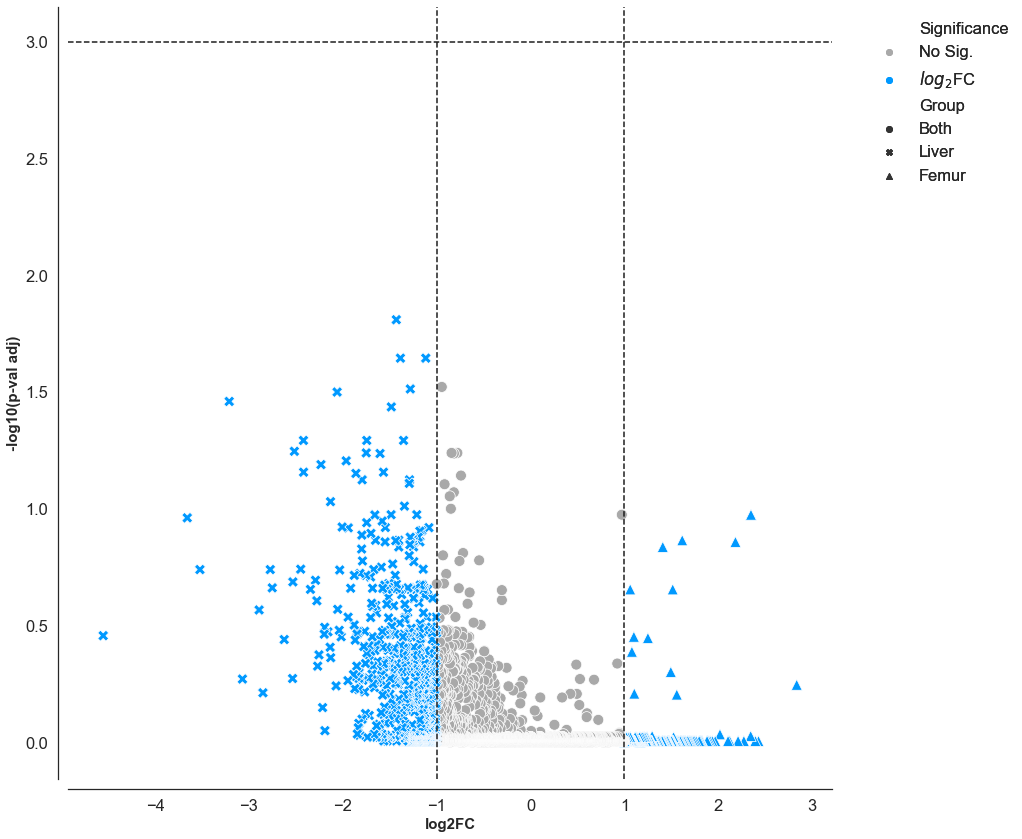

In [30]:
dataframe, fig = runDE_analysis(whole,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                plotGenes = True)

DEGs = dataframe[dataframe["difference"]=="High"]

## Liver

In [31]:
DEGs_liver = DEGs[DEGs["group"] == "Liver"].index.tolist()

print("* Using the DEGs ...")
query = liver.var[liver.var.index.isin(DEGs_liver)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(liver.raw.X > 0, axis=0)/liver.n_obs)
df       = pd.DataFrame(index=liver.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))


res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 7025

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!


## Femur

In [32]:
DEGs_femur = DEGs[DEGs["group"] == "Femur"].index.tolist()

print("* Using the DEGs ...")
query = femur.var[femur.var.index.isin(DEGs_femur)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(femur.raw.X>0, axis=0)/femur.n_obs)
df       = pd.DataFrame(index=femur.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))

res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 5602

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!


# GPs

In [33]:
group1 = pd.read_csv("../MetaData/Resources/Subsampling/ShortGroup_GPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/Subsampling/Subsampled_GPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

whole = merged[merged.obs.index.isin(group1+group2)]

np.unique(whole.obs["Cluster"])

array(['GPs'], dtype=object)

In [34]:
liver = whole[whole.obs["origin"]=="Liver"]
femur = whole[whole.obs["origin"]=="Femur"]

Trying to set attribute `.uns` of view, copying.


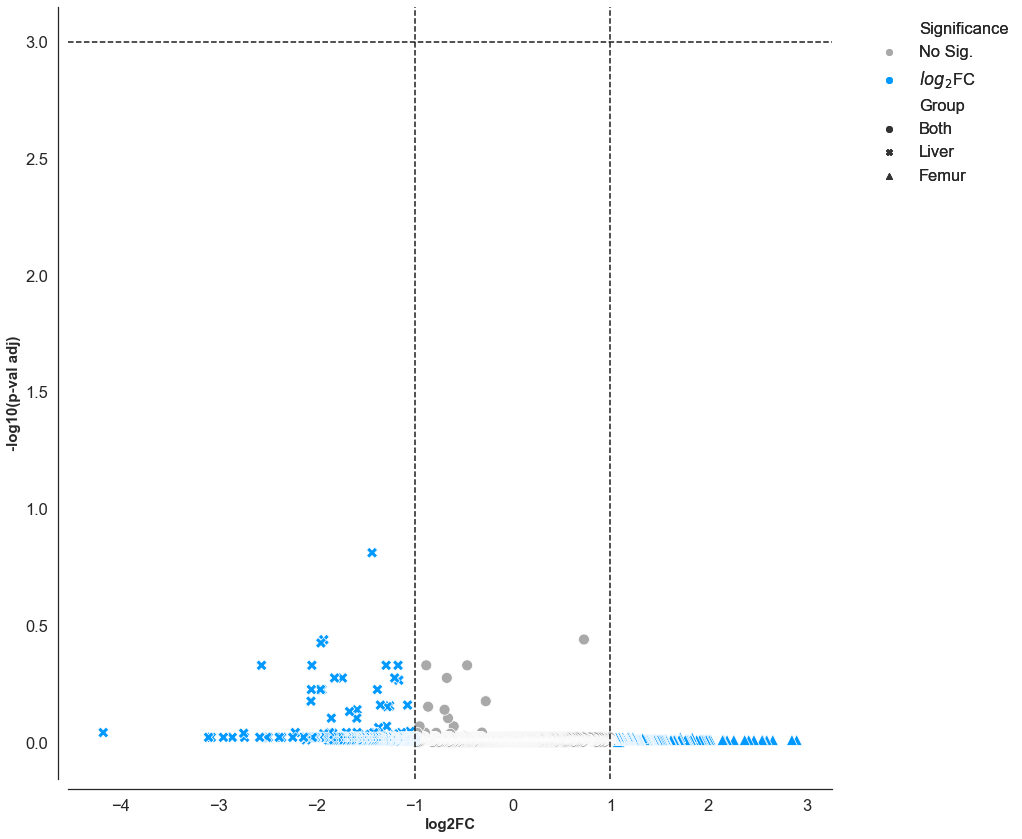

In [35]:
dataframe, fig = runDE_analysis(whole,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                plotGenes = True)

DEGs = dataframe[dataframe["difference"]=="High"]

## Liver

In [36]:
DEGs_liver = DEGs[DEGs["group"] == "Liver"].index.tolist()

print("* Using the DEGs ...")
query = liver.var[liver.var.index.isin(DEGs_liver)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(liver.raw.X > 0, axis=0)/liver.n_obs)
df       = pd.DataFrame(index=liver.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))


res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 6759

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!


## Femur

In [37]:
DEGs_femur = DEGs[DEGs["group"] == "Femur"].index.tolist()

print("* Using the DEGs ...")
query = femur.var[femur.var.index.isin(DEGs_femur)]["Ensembl"].tolist()

print("* Calculating the background genes expressed in at least %.2f%% of cells...\n"%th_perc_cells)
exp      = np.array(100*np.sum(femur.raw.X>0, axis=0)/femur.n_obs)
df       = pd.DataFrame(index=femur.var["Ensembl"], columns=["% cells"], data=exp)
bg_genes = df[df["% cells"] > th_perc_cells].index.tolist()

print("* Number of query genes: %d"%len(query))
print("* Number of background genes: %d\n"%len(bg_genes))

res = runPathwaysAnalysis(query,
                          sources                       = sources,
                          background                    = bg_genes,
                          make_plot                     = True,
                          set_domain_scope              = "custom_annotated",
                          significance_threshold_method = "bonferroni",
                          user_threshold                = 0.01)

* Using the DEGs ...
* Calculating the background genes expressed in at least 30.00% of cells...

* Number of query genes: 0
* Number of background genes: 6022

* Setting 'domain_scope' = 'custom_annotated' ('background' is not None)
* Using sources: GO:MF|GO:CC|GO:BP|KEGG|REAC|TF|MIRNA
* There query set is empty!
